# Discovery de ML Não-Supervisionado
No próximo passo do projeto, vamos tentar aplicar métodos não-supervisionados aos datasets. Inicialmente, esse notebook tem o objetivo de me familiarizar com a interface do Scikit-Learn, além de elaborar o melhor método possível para comparação entre a saída dos algoritmos e a classificação do dataset original.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, adjusted_rand_score, normalized_mutual_info_score, accuracy_score

In [17]:
df = pd.read_csv('../files/5G_attack_detection_ds.csv')

# Preparar ds para treinamento
X = df.iloc[:, :-1]

# Normalizar dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

y = df.iloc[:, -1]

## K-Means
O algoritmo [K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) busca separar os dados em n grupos de mesma variância. O número de grupos deve ser especificado.

In [21]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)

labels = kmeans.labels_
labels

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

Vamos usar uma função para comparar as labels de saída com as labels reais (feita pelo GPT), com as seguintes métricas:
- Adjusted Rand Index: computa similaridade entre clusterings, de 0 a 1;
- Normalized Mutual Information: computa a Informação Mútua, também no intervalo de 0 a 1;
- Accuracy.

In [31]:
def compare_labels(real_label, pred_label):
    ari = adjusted_rand_score(real_label, pred_label)

    nmi = normalized_mutual_info_score(real_label, pred_label)

    # Since k-means labels might not match the actual labels, we need to find the best match Function to compute accuracy
    def compute_accuracy(real_label, pred_label):
        contingency  = confusion_matrix(real_label, pred_label)
        # The accuracy is the sum of the maximum values in each row (or column)
        return np.sum(np.amax(contingency, axis=0)) / np.sum(contingency)

    accuracy = compute_accuracy(real_label, pred_label)

    return {'ari': ari,'nmi': nmi,'accuracy': accuracy}

In [32]:
print(compare_labels(y, labels))

{'ari': 0.24447594770256206, 'nmi': 0.3397061495757161, 'accuracy': 0.7472284272358732}


Claramente não há uma boa pontuação com os hiperparâmetros escolhidos. Vamos, então, tentar rodar com mais clusters e avaliar os melhores resultados:

In [42]:
def kmeans_cluster_size_exploration(df, real_label, cluster_size=range(2,10)):
    results = {'num_clusters': [], 'ari': [], 'nmi': [], 'accuracy': []}

    for k in cluster_size:
        kmeans = KMeans(n_clusters=k, random_state=42)
        pred_label = kmeans.fit_predict(df)

        score = compare_labels(real_label, pred_label)

        results['num_clusters'].append(k)
        for s in score:
            results[s].append(score[s])
    
    return results
    

In [43]:
results = kmeans_cluster_size_exploration(X, y, range(2,20))

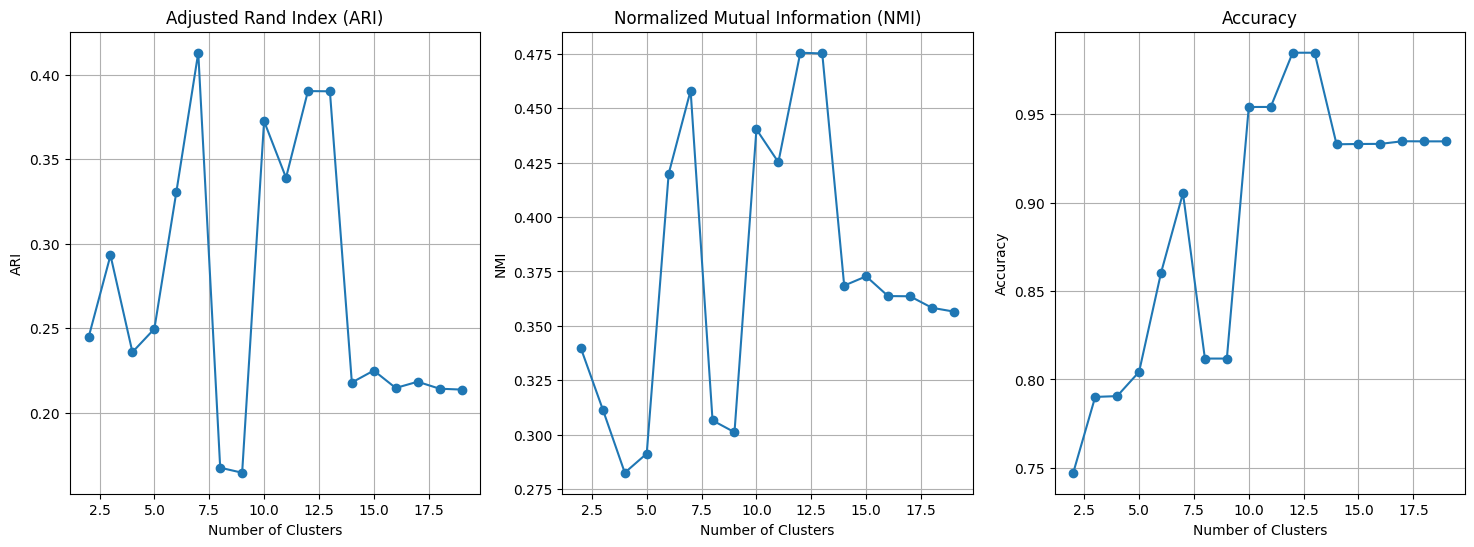

In [44]:
results_df = pd.DataFrame(results)

# Plot the results
plt.figure(figsize=(18, 6))

# Plot ARI
plt.subplot(1, 3, 1)
plt.plot(results_df['num_clusters'], results_df['ari'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('ARI')
plt.title('Adjusted Rand Index (ARI)')
plt.grid(True)

# Plot NMI
plt.subplot(1, 3, 2)
plt.plot(results_df['num_clusters'], results_df['nmi'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('NMI')
plt.title('Normalized Mutual Information (NMI)')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 3)
plt.plot(results_df['num_clusters'], results_df['accuracy'], marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)


# Display the plots
plt.show()